In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qutip
from qutip import *

from functionsSqueeze import w, wdot, H, getParams, plotResults


Units: time in $\mu s$ and circular frequency in MHz<br/>
    $\hbar$ is set to 1 => the hamiltonian has unit MHz

In [65]:
n = 50 # numerical accuracy
psi0 = thermal_dm(n, 0.01)
w0 = 2*np.pi * 2.5 # in MHz

timesQ = np.linspace(-0.9,0.7, 300)
argsQ = {'n': n,
       'omega': w,
       'omegaDt': wdot,
       'omegaArgs': [w0, -0.7*w0, 0.18, 0, 0, 0],
       'f0': 0.002/(9*10**-15)}

timesP = np.linspace(-0.1,0.5, 300)
argsP = {'n': n,
       'omega': w,
       'omegaDt': wdot,
       'omegaArgs': [w0, 0, 0.18, 0.5*w0, 4*np.pi/(2*w0), 0.],
       'f0': 0.002/(9*10**-15)}

timesQP = np.linspace(-0.8,1, 900)
argsQP = {'n': n,
       'omega': w,
       'omegaDt': wdot,
       'omegaArgs': [w0, -0.5*w0, 0.18, 0.3*w0, 4*np.pi/(2*w0), 0.3],
       'f0': 0.002/(9*10**-15)}

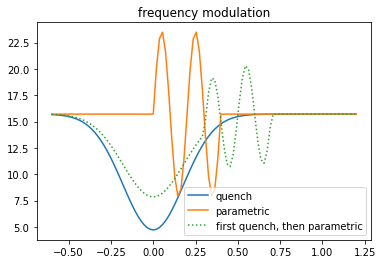

In [66]:
# plot different frequency modulations

w0 = 2*np.pi * 2.5

tlist = np.linspace(-0.6,1.2,100)


wQuench = w(tlist, argsQ['omegaArgs'])
# wQuenchD = wdot(tlist, w0=w0, dwQ=-0.9*w0, dtQ=0.18)
wParam = w(tlist, argsP['omegaArgs'])
wBoth = w(tlist, argsQP['omegaArgs'])

plt.plot(tlist, wQuench, label="quench")
# plt.plot(tlist, wQuenchD, label="quench diff")
plt.plot(tlist, wParam, label="parametric")
plt.plot(tlist, wBoth,":", label="first quench, then parametric")
plt.legend()
plt.title("frequency modulation")
plt.show()

In [46]:
resultQ = mesolve(H, psi0, timesQ, args=argsQ)

In [47]:
resultP = mesolve(H, psi0, timesP, args=argsP)

In [ ]:
resultQP = mesolve(H, psi0, timesQP, args=argsQP)

In [ ]:
result = resultQP

psi = result.states[-1]

plot_wigner_fock_distribution(psi)
plt.show

In [ ]:
alpha, xi, nBar, nT = getParams(psi)

# psiT = squeeze(n, np.conj(xi)).dag()*displace(n, alpha).dag()*psi*displace(n, alpha)*squeeze(n, np.conj(xi))

# nT = expect(num(20), psiT)

print('|alpha|=', np.abs(alpha), ', xi =', xi, ', nBar =', nBar, ', nT =', nT)

psi1 = displace(n, alpha)*squeeze(n, xi)*thermal_dm(n, nT)*squeeze(n, xi).dag()*displace(n, alpha).dag()
plot_wigner_fock_distribution(psi1)
plt.show()

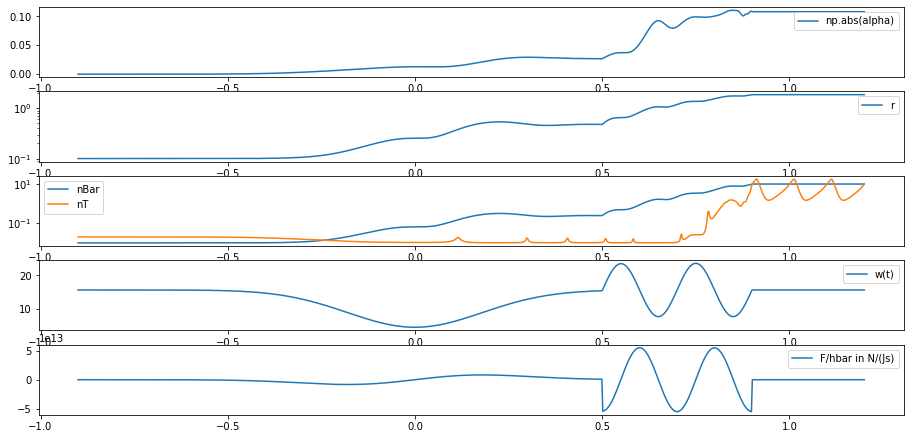

0

In [64]:
plotResults(timesQP, resultQP, argsQP)

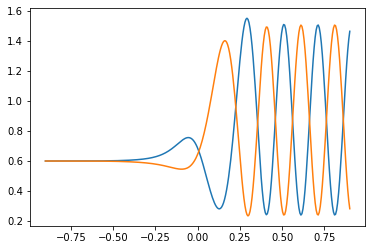

In [69]:
# dimensionless position and momentum operators
result = resultQ
times = timesQ

ad = create(n)
a = destroy(n)
x = 1/np.sqrt(2)*(ad + a)
p = 1/np.sqrt(2)*(ad - a)

# plot variance of x and p with time
varX = expect(x*x.dag(), result.states)
varP = expect(p*p.dag(), result.states)
plt.plot(times, varX, label = "variance of x")
plt.plot(times, varP, label = "variance of p")